<a href="https://colab.research.google.com/github/zihadbappy/bnfake/blob/main/Md_Gulzar_BNBanglaBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!git clone https://github.com/zihadbappy/FakeDatasets.git

fatal: destination path 'FakeDatasets' already exists and is not an empty directory.


In [16]:
import pandas as pd
Dataset= pd.read_excel('/content/FakeDatasets/FinalData1.xlsx')

In [17]:
df= Dataset.filter(['Title','Statement', 'Class'], axis=1)
df.loc[(df.Class=='Real'),'Class']=1
df.loc[(df.Class=='Fake'),'Class']=0
df['Class']=df['Class'].astype('int')
df['Class'].dtypes

dtype('int64')

In [18]:
df.columns=['headline', 'content', 'label']
df.groupby('label').agg('count')

,headline,content
label,,
0,993,993
1,1548,1548


In [19]:
df = df.drop_duplicates(subset='headline', keep="first")
df.groupby('label').agg('count')

,headline,content
label,,
0,948,948
1,1545,1545


In [20]:
df.headline.duplicated().sum()

0

In [21]:
df.groupby('label').agg('count')

,headline,content
label,,
0,948,948
1,1545,1545


In [22]:
import re
from re import sub
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations
                               
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)
    
    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''
    
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out
df['headline'] = df.headline.apply(lambda x: preprocessing(str(x)))
df['content'] = df.content.apply(lambda x: preprocessing(str(x)))

In [23]:
df['content'] = df['content'].str.replace(r'\n', ' ')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [24]:
df = df.reset_index(drop=True)


In [25]:
pip install bnlp_toolkit


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

word_list= []
def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
        word_list.append(i)
    return " ".join(filtered)

# print("********** Before ***************")
# text = df.iloc[1]['content']
# print(text)
# print("\n********** After ***************")
# print(clean_text(text))
df['content'] = df.content.apply(clean_text)

In [27]:
# print(len(set(word_list))
uniq=set(word_list)

In [28]:
X=df.content
Y=df.label

In [29]:
pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 7.4 MB/s 
     |████████████████████████████████| 6.6 MB 46.0 MB/s 
     |████████████████████████████████| 120 kB 75.8 MB/s 


In [30]:
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import BertModel, BertTokenizer, BertForSequenceClassification

In [31]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['headline']+"[SEP]"+value['content'] , value['label']

In [32]:
class NewsBert(nn.Module):

    def __init__(self, bert):
        super(NewsBert, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x
      

In [33]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)


Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NewsBert(bert)
model.to(device);

In [35]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [36]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.25, random_state=121, stratify=df['label'])

In [37]:
len(train_df), len(test_df)

(1869, 624)

In [38]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)

In [39]:
type(training_data)

__main__.NewsDatasets

In [40]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

In [41]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [42]:
epochs = 8
tokenizer_config = {
    "max_length": 300,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [43]:
def train(model, dataloader, optimizer, criterion, config):
    model.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [44]:
test_df

,headline,content,label
1139,সিলেট জেলা লকডাউন,করোনাভাইরাসের প্রাদুর্ভাব ঠেকাতে সিলেট জেলাকে ...,1
8,বিশেষ চাহিদাসম্পন্ন সন্তান ও অভিভাবকদের ভোগান্...,করোনাভাইরাসের বিস্তারের সময়ে অটিস্টিক ডাউন সিন...,1
1447,এখনই তো সময় ভালোবাসার,দেখুন নীরবনিস্তরঙ্গ হয়ে চারপাশটা কখনো কখনো কাছ...,1
1460,গণহত্যা সনদ মেনে চলার নির্দেশ জারি করল মিয়ানমা...,গণহত্যা সনদ মেনে চলা রাখাইন রাজ্যে সংঘটিত সহিং...,1
815,নিউইয়র্কের গৃহহীনদের হোটেলে আশ্রয় দেওয়া হচ্ছে,করোনাভাইরাসের সংক্রমন বাঁচাতে নিউইয়র্কের ছয় গৃ...,1
...,...,...,...
1994,\n\t\t\t\t\t\t\tব্রেক বেংকের বিরুদ্ধে সন্ত্রাস...,অর্থনীতী মতিবেদক নাইট পদবীর অধিকারী ফজলে হোসেন...,0
2417,\nআগুনের ভয়ে মল ত্যাগ করলেন তাহসান খান\n,একের এক ঘটনার জন্ম দিয়েই যাচ্ছেন যৌনপ্রিয় কন্ঠ...,0
2263,\n\t\t\t\t\t\t\tচট্টগ্রামে মাদকব্যবসার অন্তরাল...,নিজস্ব মতিনিধি চট্টগ্রামের মাদক সরাবরাহ পরিবহন...,0
56,আমি আশা নিয়ে বাঁচতে চাই,আনা ফ্রাঙ্ক ইতিহাসে অমর হয়ে আছেন দ্বিতীয় বিশ্ব...,1


In [45]:
train_loss_data=[]
valid_loss_data = []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
  print("Epoch: {}/{}".format(epoch + 1, epochs))
  # monitor training loss
  train_loss = 0.0
  valid_loss = 0.0
  total = 0
  correct = 0
  e_since = time.time()

    # Train Model
  train_loss += train(model, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
  out = evaluate(model, test_dataloader, criterion, tokenizer_config)
  total += out[0]
  correct += out[1]
  valid_loss += out[2]  
  scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
  train_loss = train_loss / len(train_dataloader.dataset)
  valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
  train_loss_data.append(train_loss * 100)
  valid_loss_data.append(valid_loss * 100)
    
  if valid_loss < best_loss:
    best_loss = valid_loss
    torch.save(model.state_dict(), "news_model1.pth")
    
  print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/8


  0%|          | 0/117 [00:00<?, ?it/s]

	Train loss:0.363715.. 	Valid Loss:0.167967.. 	Accuracy: 94.8718
Epoch: 2/8


  0%|          | 0/117 [00:00<?, ?it/s]

	Train loss:0.107871.. 	Valid Loss:0.097118.. 	Accuracy: 97.4359
Epoch: 3/8


  0%|          | 0/117 [00:00<?, ?it/s]

	Train loss:0.044974.. 	Valid Loss:0.085331.. 	Accuracy: 97.4359
Epoch: 4/8


  0%|          | 0/117 [00:00<?, ?it/s]

	Train loss:0.041136.. 	Valid Loss:0.085869.. 	Accuracy: 97.5962
Epoch: 5/8


  0%|          | 0/117 [00:00<?, ?it/s]

	Train loss:0.039278.. 	Valid Loss:0.084570.. 	Accuracy: 97.7564
Epoch: 6/8


  0%|          | 0/117 [00:00<?, ?it/s]

	Train loss:0.038283.. 	Valid Loss:0.083644.. 	Accuracy: 97.7564
Epoch: 7/8


  0%|          | 0/117 [00:00<?, ?it/s]

	Train loss:0.038854.. 	Valid Loss:0.083629.. 	Accuracy: 97.7564
Epoch: 8/8


  0%|          | 0/117 [00:00<?, ?it/s]

	Train loss:0.036845.. 	Valid Loss:0.083627.. 	Accuracy: 97.7564
Training completed in 18m 22s


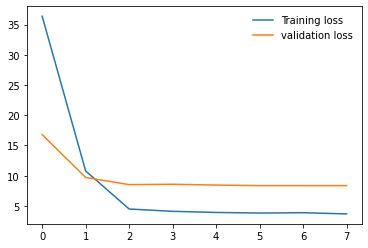

In [46]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [47]:
model.load_state_dict(torch.load("./news_model1.pth", map_location = device))

<All keys matched successfully>

In [48]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [49]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       237
           1       0.98      0.99      0.98       387

    accuracy                           0.98       624
   macro avg       0.98      0.97      0.98       624
weighted avg       0.98      0.98      0.98       624



In [50]:
all_labels[1000:1020]

[]

In [51]:
all_preds[1000:1020]

[]